This code analyses FoR embeddings within each time period, using cosine and neighbourhood similarity measures.

* Author: Barbara McGillivray
* Date: March 2020 to July 2021
* Based on code written by Khalid and Donna.



# Initialization


In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True) 
%ls '/gdrive/My Drive/SpringerNature-Google-Turing/data/'

Mounted at /gdrive
 Five-year-sg-d100-w2-ns5/            Mean-title-centroids-3yrs-v02/
 Five-year-sg-d12-w4-ns1/             Three-year-sg-d100-w2-ns5/
 Five-year-sg-d12-w4-ns5/             Three-year-sg-d12-w2-ns1/
 for_co-occurrence_counts_11-13.csv   Three-year-sg-d12-w2-ns2/
 for_co-occurrence_counts_14-16.csv   Three-year-sg-d12-w2-ns3/
 for_co-occurrence_counts_17-19.csv   Three-year-sg-d12-w2-ns5/
 for_levels.csv                       Three-year-sg-d12-w4-ns1/
'FoR mapping - Extract 1.csv'         Three-year-sg-d12-w4-ns2/
'FoR mapping - Extract 1.gsheet'      Three-year-sg-d12-w4-ns3/
 for_nsize_density.csv                Three-year-sg-d12-w4-ns5/
 for_nsize_negcorr.csv                Three-year-sg-journals/
 FoR-Ontology.csv                     wv_11_13.txt
 for_regression_coef.csv              wv_14_16.txt
 FoR_W2V_v01.html                     wv_17_19.txt
 Mean-title-centroids-3yrs/


In [2]:
import os
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict, OrderedDict
import numpy as np
import pandas as pd
from statistics import median, mean
from os import listdir
from os.path import isfile, join
import re
import plotly.express as px
import matplotlib.pyplot as plt
import statistics
import glob
from datetime import datetime
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Parameters

Note that window_size = 2 and negative_sampling = 1 are the best hyperparameters according to the intrinsic evaluation, so we choose these.

In [3]:
# options are: 
#     "forembbyarticle" for co-occurrence-based FoR embeddings at the article level
#     "title" for aggregated title embeddings
#     "forembbyjournal" for FoR-code co-occurrences aggregated at the journal level.
embedding_type = "forembbyarticle" 
f_code = "f2" # level of FoR codes for which the embeddings are created, can be f1 or f2 can be f1 or f2
if embedding_type == "title":
  year_intervals = 3
  num_dimensions = 512
elif embedding_type == "forembbyarticle":
  year_intervals = 3 
  num_dimensions = 12 # number of dimensions of embeddings
  window_size = 2 
  negative_sampling = 1
  f_code = "f2" # level of FoR codes for which the embeddings are created; it is f2
elif embedding_type == "forembbyjournal":
  year_intervals = 3
  num_dimensions = 100
  f_code = "f2"


In [4]:
last_year = 2019
#if year_intervals == 3:
first_year = 1990 
#if year_intervals == 5:
#  first_year = 1950 # this doesn't apply because we have excluded old embeddings from our analysis

In [5]:
BASE_DIR = '/gdrive/My Drive/SpringerNature-Google-Turing'
DATA_DIR = BASE_DIR + '/data'
if embedding_type == "forembbyarticle":
  if year_intervals == 3:
    years_words = "Three"
  elif year_intervals == 5:
    years_words = "Five"
  DATA_DIR_yrs = DATA_DIR + '/' + years_words + '-year-sg-d' + str(num_dimensions) + '-w' + str(window_size) + '-ns' + str(negative_sampling)
elif embedding_type == "title":
  DATA_DIR_yrs = os.path.join(DATA_DIR, 'Mean-title-centroids-3yrs-v02')
elif embedding_type == "forembbyjournal":
  DATA_DIR_yrs = os.path.join(DATA_DIR, "Three-year-sg-journals")

# Functions

Function for loading embeddings

In [6]:
# Function that loads the embeddings from the embedding file (From Khalid's and Donna's script)
def load_embeddings(embedding_file):

  embeddings = {}
  with open(os.path.join(DATA_DIR_yrs, embedding_file)) as file_reader:
    lines = file_reader.readlines()
    
    # skip the first line
    lines = lines[1:]

    # parse embedding lines
    for line in lines:
      parts = line.split(' ')
      embedding = [float(value) for value in parts[-num_dimensions:]]
      field = ' '.join(parts[:-num_dimensions])
      embeddings[field] = embedding

  return embeddings

Function for calculating pairwise cosine similarity scores


In [7]:
def compute_pairwise_similarities(embedding_dict):
  # store pairwise similarities
  pairwise_embedding_similarities = defaultdict(dict)

  # get list of topics
  topics = list(embedding_dict.keys())

  total_similarity = 0
  similarity_distribution = list() # list of similarity values
  count = 0

  for i in range(len(topics)):
    #for j in range(i + 1, len(topics)):
    for j in range(len(topics)):
      topic_1 = topics[i]
      topic_2 = topics[j]
      #topic_1, topic_2 = max(topic_1, topic_2), min(topic_1, topic_2)

      # get first topic's embedding
      embed1 = embedding_dict[topic_1]
      # get second topic's embedding
      embed2 = embedding_dict[topic_2]
      # compute cosine similarity
      similarity = cosine_similarity([embed1], [embed2])
      # store in dictionary
      pairwise_embedding_similarities[topic_1][topic_2] = float(similarity)
      total_similarity += float(similarity)
      similarity_distribution.append(float(similarity))
      count += 1
  
  # Order topics by similarity
  for topic in pairwise_embedding_similarities:
    dictionary = pairwise_embedding_similarities[topic]
    sorted_dictionary = OrderedDict(sorted(dictionary.items(), key=lambda x: x[1], reverse=True))
    pairwise_embedding_similarities[topic] = sorted_dictionary

  return pairwise_embedding_similarities, total_similarity / count, median(similarity_distribution)

Functions for calculating neighbourhood size


In [8]:
def get_nearest_neighbours(similarities, topic, k):
  return list(similarities[topic].items())[1:k+1]

In [9]:
def get_neighbourhood(similarities, topic, distance):
  results = []
  for item in similarities[topic].items():
    t, similarity = item
    if similarity >= 1- distance and topic != t :
      results.append(item)
  return results

In [10]:
def get_neighbourhood_sizes(similarities, distance):
  results = {}
  sizes = []
  topics = list(similarities.keys())
  for topic in topics:
    results[topic] = len(get_neighbourhood(similarities, topic, distance))
    sizes.append(results[topic])
  return results, mean(sizes), median(sizes)


In [11]:
def get_average_neighbourhood_sizes(similarities, distances=np.arange(0.01, 0.31, 0.01)):
  sizes = {}
  for distance in distances:
    _, avg_size, median_size = get_neighbourhood_sizes(similarities, distance)
    sizes[round(distance, 3)] = round(avg_size, 5)
  return sizes

def get_median_neighbourhood_sizes(similarities, distances=np.arange(0.01, 0.31, 0.01)):
  sizes = {}
  for distance in distances:
    _, avg_size, median_size = get_neighbourhood_sizes(similarities, distance)
    sizes[round(distance, 3)] = round(median_size, 5)
  return sizes


# Read data

Read embedding files


In [12]:
if embedding_type in ["forembbyarticle", "forembbyjournal"]:
  embeddingfiles = [f for f in listdir(DATA_DIR_yrs) if isfile(join(DATA_DIR_yrs, f))]
elif embedding_type == "title":
  embeddingfiles = glob.glob(os.path.join(DATA_DIR_yrs, "*{}.csv".format(f_code)))
print("There are", str(len(embeddingfiles)), "embedding files")


There are 10 embedding files


In [13]:
year2embeddings = dict() # dictionary that maps a year_start to the embedding file for that (year, year + year_intervals) period
for f in embeddingfiles:
  if embedding_type in ["forembbyarticle", "forembbyjournal"]:
    m = re.match(r'wv_(\d\d)_(\d\d)', f)
  elif embedding_type == "title":
    m = re.match(r'.*?wv_(\d\d)_(\d\d).*?', f)
  year_start = m.group(1)
  #year_end = m.group(2)
  #print("file", f, "Year start:", str(year_start), "Year end:", str(year_end))
  year2embeddings[int(year_start)] = f
print(str(year2embeddings))

{17: 'wv_17_19.txt', 14: 'wv_14_16.txt', 11: 'wv_11_13.txt', 8: 'wv_08_10.txt', 5: 'wv_05_07.txt', 2: 'wv_02_04.txt', 99: 'wv_99_01.txt', 96: 'wv_96_98.txt', 93: 'wv_93_95.txt', 90: 'wv_90_92.txt'}


## Load embeddings


In [14]:
all_embeddings = dict() # Dictionary that maps a year_start with the embeddings for the (year, year + year_intervals-1) period; 
# the embeddings are dictionaries that map a FoR to the list of its embedding's numeric values
#print(str(first_year), "!")
#print(str(last_year), "!")
for y in range(first_year, last_year, year_intervals):
  #print("Year", str(y))
  y0 = int(str(y)[2:4])
  #print("y0=", str(y0))
  embeddings = load_embeddings(year2embeddings[y0])
  all_embeddings[y] = embeddings
  

# Cosine similarity analysis




### Validate the loaded embeddings 

In [15]:
print("Parsed embedding count: {}.".format(len(all_embeddings.items())))
valid = True
for y in range(first_year, last_year, year_intervals):
  print("Validating embedddings for year", str(y))#, str(all_embeddings[y]))
  embedding_dict = all_embeddings[y]
  for field in embedding_dict: 
    #print("field", field, "embedding", str(embedding_dict[field]))
    if len(embedding_dict[field]) != num_dimensions:
      #print("Embedding shorter than expected!", str(len(embedding_dict[field])))
      valid = False
      break

if valid:
  print("All embeddings have size ", str(num_dimensions))

Parsed embedding count: 10.
Validating embedddings for year 1990
Validating embedddings for year 1993
Validating embedddings for year 1996
Validating embedddings for year 1999
Validating embedddings for year 2002
Validating embedddings for year 2005
Validating embedddings for year 2008
Validating embedddings for year 2011
Validating embedddings for year 2014
Validating embedddings for year 2017
All embeddings have size  12


Create output file for reports


In [16]:
DIR_OUT = os.path.join(BASE_DIR, 'analysis')
if not os.path.exists(DIR_OUT):
    os.makedirs(DIR_OUT)

if embedding_type == "forembbyarticle":
  out_file = open(os.path.join(DIR_OUT, 'Similarity-analysis_'+embedding_type + 
                               '-embeddings' + 
                               '_Year_intervals-' + str(year_intervals) + 
                               '_level-' + str(f_code) +
                              '_num_dimensions-' + str(num_dimensions) + 
                              '_window_size-' + str(window_size) + 
                               '_negative_sampling-' + str(negative_sampling) + 
                               '.txt'), 'w')
elif embedding_type in ["title", "forembbyjournal"]:
  out_file = open(os.path.join(DIR_OUT, 'Similarity-analysis_'+embedding_type +
                               '-embeddings' + 
                               '_Year_intervals-' + str(year_intervals) + 
                               '_level-' + str(f_code) +
                               '_num_dimensions-' + str(num_dimensions) + 
                               '.txt'), 'w') 


In [17]:
if year_intervals == 3:
  similarities_1990, average_similarity_1990, median_similarity_1990 = compute_pairwise_similarities(all_embeddings[1990])
  similarities_2017, average_similarity_2017, median_similarity_2017 = compute_pairwise_similarities(all_embeddings[2017])
  print("Average and median similarity for 1990", str(round(average_similarity_1990,2)), ", ", str(round(median_similarity_1990,2)))
  print("Average and median similarity for 2017", str(round(average_similarity_2017,2)), ", ", str(round(median_similarity_2017,2)))


Average and median similarity for 1990 0.19 ,  0.17
Average and median similarity for 2017 0.24 ,  0.21


In [18]:
year2average_similarity = dict() # maps a year to the average similarity for that year
year2median_similarity = dict() # maps a year to the median similarity for that year
year2similarities = dict() # maps a year to the similarity scores for that year
for y in range(first_year+year_intervals, last_year, year_intervals):
  print(y)
  similarities_year, average_similarity_year, median_similarity_year = compute_pairwise_similarities(all_embeddings[y])
  year2average_similarity[y] = average_similarity_year
  year2median_similarity[y] = median_similarity_year
  year2similarities[y] = similarities_year

1993
1996
1999
2002
2005
2008
2011
2014
2017


In [19]:
#print(str(year2average_similarity))
print("Early periods", str([y for y in year2average_similarity if y < first_year + round((last_year-first_year)/2)]))
#print(str([year2average_similarity[y] for y in year2average_similarity if y < first_year + round((last_year-first_year)/2)]))
print("Late periods", str([y for y in year2average_similarity if y >= first_year + round((last_year-first_year)/2)]))
#print(str([year2average_similarity[y] for y in year2average_similarity if y >= first_year + round((last_year-first_year)/2)]))
year2average_similarity_early = statistics.mean([year2average_similarity[y] for y in year2average_similarity if y < first_year + round((last_year-first_year)/2)])
year2average_similarity_late = statistics.mean([year2average_similarity[y] for y in year2average_similarity if y >= first_year + round((last_year-first_year)/2)])
print("Average similarity in earlier years: {}".format(round(year2average_similarity_early, 3)))
print("Average similarity in later years: {}".format(round(year2average_similarity_late, 3)))
year2median_similarity_early = statistics.mean([year2median_similarity[y] for y in year2median_similarity if y < first_year + round((last_year-first_year)/2)])
year2median_similarity_late = statistics.mean([year2median_similarity[y] for y in year2median_similarity if y >= first_year + round((last_year-first_year)/2)])
print("Median similarity in earlier years: {}".format(round(year2median_similarity_early, 3)))
print("Median similarity in later years: {}".format(round(year2median_similarity_late, 3)))


Early periods [1993, 1996, 1999, 2002]
Late periods [2005, 2008, 2011, 2014, 2017]
Average similarity in earlier years: 0.215
Average similarity in later years: 0.234
Median similarity in earlier years: 0.192
Median similarity in later years: 0.211


Print report to output file


In [ ]:
if year_intervals == 3:
  out_file.write("Average and median cosine similarity for 1990: "+str(average_similarity_1990)+", "+str(median_similarity_1990)+"\n")
  out_file.write("Average and median cosine similarity for 2017: "+str(average_similarity_2017)+", "+str(median_similarity_2017)+"\n")

out_file.write("Average cosine similarity in earlier years: {}".format(round(year2average_similarity_early, 3))+"\n")
out_file.write("Average cosine similarity in later years: {}".format(round(year2average_similarity_late, 3))+"\n")
out_file.write("Median cosine similarity in earlier years: {}".format(round(year2median_similarity_early, 3))+"\n")
out_file.write("Median cosine similarity in later years: {}".format(round(year2median_similarity_late, 3))+"\n")


47

Create data frame for visualization, containing the average cosine similarity between all pairs of embeddings for each year

In [20]:
year2average_similarity_df = pd.DataFrame(year2average_similarity.items())
year2average_similarity_df.columns = ["year", "cosine"]
year2average_similarity_df.head()

,year,cosine
0,1993,0.184618
1,1996,0.209116
2,1999,0.237238
3,2002,0.229786
4,2005,0.235325


Visualization

In [21]:
px.line(year2average_similarity_df, x = "year", y = "cosine")

Save image file


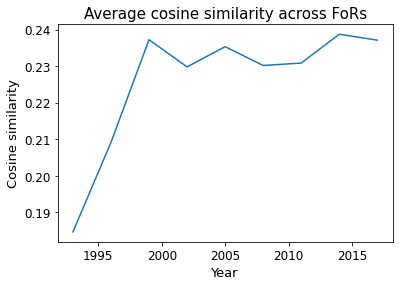

In [ ]:
year2average_similarity_df.plot(x="year", y="cosine", legend=None)
#plt.ylim(0, 1)
title = ""
if embedding_type == "forembbyarticle":
  title = 'Average cosine similarity across FoRs' # ('+ embedding_type + ' embeddings)'
elif embedding_type in ["title", "forembbyjournal"]:
  title = 'Average cosine similarity across FoRs' #('+ embedding_type + ' embeddings,' + ' level ' + str(f_code) + ')'
plt.title(title,fontsize= 15)
plt.xlabel('Year', fontsize=13)
plt.ylabel('Cosine similarity', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
if embedding_type == "forembbyarticle":
  image_file_name = os.path.join(DIR_OUT, 
                                 'FoR_average_cos-sim_time-series_'+embedding_type + 
                               '-embeddings' + 
                               '_Year_intervals-' + str(year_intervals) + 
                               '_level-' + str(f_code) +
                              '_num_dimensions-' + str(num_dimensions) + 
                              '_window_size-' + str(window_size) + 
                               '_negative_sampling-' + str(negative_sampling) + 
                               '.png')
elif embedding_type in ["title", "forembbyjournal"]:
  image_file_name = os.path.join(DIR_OUT, 
                                 'FoR_average_cos-sim_time-series_'+embedding_type + 
                               '-embeddings' + 
                               '_Year_intervals-' + str(year_intervals) + 
                               '_level-' + str(f_code) +
                               '_num_dimensions-' + str(num_dimensions) + 
                               '.png')
plt.savefig(os.path.join(DIR_OUT, image_file_name))

## Trend test

I use the Mann Kendall test to see if the cosine similarity has a statistically significant upward or downward trend:

In [ ]:
(cor, p) = scipy.stats.kendalltau(year2average_similarity_df['year'], year2average_similarity_df['cosine'])
(cor, p)

(0.5555555555555556, 0.04461529982363316)

In [ ]:
out_file.write("Results of Mann Kendall correlation test on average cosine similarity: corr = {}, p-value = {}".format(cor, p) + "\n")
if p < 0.05:
  out_file.write("Statistically significant\n")
else:
  out_file.write("Not statistically significant\n")

# Neighbourhood size analysis

Average neighbourhood size by year

In [22]:
# Given a list of distances (by default 0.01, 0.02, ..., 0.1), the function returns the average neighbourhood size for each distance.
year2average_neighsizes = dict() # maps a year to the average size of the neighbourhood for that year
for y in range(first_year+year_intervals, last_year, year_intervals):
  average_neighsizes_year = get_average_neighbourhood_sizes(year2similarities[y])
  year2average_neighsizes[y] = average_neighsizes_year
print("Average neighbourhood sizes:")
print(str(year2average_neighsizes))
print("Early year periods", str([y for y in year2average_neighsizes if y < first_year + round((last_year-first_year)/2)]))
print(str([year2average_neighsizes[y] for y in year2average_neighsizes if y < first_year + round((last_year-first_year)/2)]))
print("Late year periods", str([y for y in year2average_neighsizes if y >= first_year + round((last_year-first_year)/2)]))
print(str([year2average_neighsizes[y] for y in year2average_neighsizes if y >= first_year + round((last_year-first_year)/2)]))
year2average_neighsizes_early = dict()
year2average_neighsizes_late = dict()
for distance in np.arange(0.01, 0.31, 0.01):
  distance = round(distance, 2)
  print(str(distance))
  year2average_neighsizes_early[distance] = [year2average_neighsizes[y][distance] for y in year2average_neighsizes if y < first_year + round((last_year-first_year)/2)]
  year2average_neighsizes_late[distance] = [year2average_neighsizes[y][distance] for y in year2average_neighsizes if y >= first_year + round((last_year-first_year)/2)]
print("Average neighbourhood size with distance 0.2 for earlier years: ",str(year2average_neighsizes_early[0.2]))
print("Average neighbourhood size with distance 0.2 for later years: ", str(year2average_neighsizes_late[0.2]))
print("Mean of the average neighbourhood size with distance 0.2 for earlier years: {}".format(round(statistics.mean(year2average_neighsizes_early[0.2]), 3)))
print("Mean of the average neighbourhood size with distance 0.2 for later years: {}".format(round(statistics.mean(year2average_neighsizes_late[0.2]), 3)))
#average_sizes_11_13 = get_average_neighbourhood_sizes(similarities_11_13)
#average_sizes_17_19 = get_average_neighbourhood_sizes(similarities_17_19)


Average neighbourhood sizes:
{1993: {0.01: 0.02817, 0.02: 0.28169, 0.03: 0.69014, 0.04: 1.19718, 0.05: 1.92958, 0.06: 2.4507, 0.07: 3.12676, 0.08: 3.71831, 0.09: 4.57746, 0.1: 5.3662, 0.11: 5.95775, 0.12: 6.50704, 0.13: 7.08451, 0.14: 7.56338, 0.15: 8.12676, 0.16: 8.73239, 0.17: 9.35211, 0.18: 9.90141, 0.19: 10.50704, 0.2: 10.95775, 0.21: 11.6338, 0.22: 12.23944, 0.23: 12.70423, 0.24: 13.05634, 0.25: 13.59155, 0.26: 14.05634, 0.27: 14.5493, 0.28: 15.11268, 0.29: 15.67606, 0.3: 16.28169}, 1996: {0.01: 0.04255, 0.02: 0.25532, 0.03: 0.55319, 0.04: 1.07801, 0.05: 1.53191, 0.06: 1.98582, 0.07: 2.58156, 0.08: 3.30496, 0.09: 3.7305, 0.1: 4.38298, 0.11: 5.14894, 0.12: 5.74468, 0.13: 6.22695, 0.14: 6.7234, 0.15: 7.14894, 0.16: 7.68794, 0.17: 8.29787, 0.18: 8.93617, 0.19: 9.64539, 0.2: 10.1844, 0.21: 10.69504, 0.22: 11.34752, 0.23: 11.88652, 0.24: 12.34043, 0.25: 12.8227, 0.26: 13.39007, 0.27: 14, 0.28: 14.43972, 0.29: 14.97872, 0.3: 15.60284}, 1999: {0.01: 0, 0.02: 0.15493, 0.03: 0.42254, 0.04:

Print to output file


In [ ]:
out_file.write("Average neighbourhood size with distance 0.2 for earlier years: "+str(year2average_neighsizes_early[0.2])+"\n")
out_file.write("Average neighbourhood size with distance 0.2 for later years: "+str(year2average_neighsizes_late[0.2])+"\n")
out_file.write("Mean of the average neighbourhood sizes with distance 0.2 for earlier years: {}".format(round(statistics.mean(year2average_neighsizes_early[0.2]), 3))+"\n")
out_file.write("Mean of the average neighbourhood sizes with distance 0.2 for later years: {}".format(round(statistics.mean(year2average_neighsizes_late[0.2]), 3))+"\n")


81

The average neighbourhood size goes down, which means that the fields are becoming more specialized.

Create subset of dictionary that contains average neighbourhood sizes for distance 0.2

In [23]:
year2average_neighsizes_02 = dict()
for y in year2average_neighsizes:
  year2average_neighsizes_02[y] = year2average_neighsizes[y][0.2]
print(str(year2average_neighsizes_02))

{1993: 10.95775, 1996: 10.1844, 1999: 8.71831, 2002: 7.02778, 2005: 6.96454, 2008: 6.11034, 2011: 5.82192, 2014: 5.24476, 2017: 5.40278}


Create data frame for visualization

In [24]:
year2average_neighsizes_02_df = pd.DataFrame(year2average_neighsizes_02.items())
year2average_neighsizes_02_df.columns = ["year", "average_neighbourhood_size_d0.2"]
year2average_neighsizes_02_df.head()

,year,average_neighbourhood_size_d0.2
0,1993,10.95775
1,1996,10.18440
2,1999,8.71831
3,2002,7.02778
4,2005,6.96454


Visualization

In [ ]:
px.line(year2average_neighsizes_02_df, x = "year", y = "average_neighbourhood_size_d0.2")

Save image


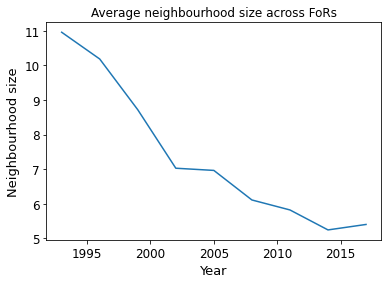

In [ ]:
year2average_neighsizes_02_df.plot(x="year", y="average_neighbourhood_size_d0.2", legend=None)
plt.title('Average neighbourhood size across FoRs')
plt.xlabel('Year', fontsize=13)
plt.ylabel('Neighbourhood size', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
if embedding_type == "forembbyarticle":
  image_file_name = os.path.join(DIR_OUT, 
                                 'FoR_average_neighbourhood-d0.2-sim_time-series_'+embedding_type + 
                               '-embeddings' + 
                               '_Year_intervals-' + str(year_intervals) + 
                               '_level-' + str(f_code) +
                              '_num_dimensions-' + str(num_dimensions) + 
                              '_window_size-' + str(window_size) + 
                               '_negative_sampling-' + str(negative_sampling) + 
                               '.png')
elif embedding_type in ["title", "forembbyjournal"]:
  image_file_name = os.path.join(DIR_OUT, 
                                 'FoR_average_neighbourhood-d0.2-sim_time-series_'+embedding_type + 
                               '-embeddings' + 
                               '_Year_intervals-' + str(year_intervals) + 
                               '_level-' + str(f_code) +
                               '_num_dimensions-' + str(num_dimensions) + 
                               '.png')


plt.savefig(image_file_name)

Median nehbourhood size by year

In [25]:
year2median_neighsizes = dict() # maps a year to the median size of the neighbourhood for that year
for y in range(first_year+year_intervals, last_year, year_intervals):
  median_neighsizes_year = get_median_neighbourhood_sizes(year2similarities[y])
  year2median_neighsizes[y] = median_neighsizes_year
print("Median sizes:")
print(str(year2median_neighsizes))
print("Early year periods", str([y for y in year2median_neighsizes if y < first_year + round((last_year-first_year)/2)]))
print(str([year2median_neighsizes[y] for y in year2median_neighsizes if y < first_year + round((last_year-first_year)/2)]))
print("Late year periods", str([y for y in year2median_neighsizes if y >= first_year + round((last_year-first_year)/2)]))
print(str([year2median_neighsizes[y] for y in year2median_neighsizes if y >= first_year + round((last_year-first_year)/2)]))
year2median_neighsizes_early = dict()
year2median_neighsizes_late = dict()
for distance in np.arange(0.01, 0.31, 0.01):
  distance = round(distance, 3)
  year2median_neighsizes_early[distance] = statistics.mean([year2median_neighsizes[y][distance] for y in year2median_neighsizes if y < first_year + round((last_year-first_year)/2)])
  year2median_neighsizes_late[distance] = statistics.mean([year2median_neighsizes[y][distance] for y in year2median_neighsizes if y >= first_year + round((last_year-first_year)/2)])
print("Earlier years: {}".format(round(year2median_neighsizes_early[0.2], 3)))
print("Later years: {}".format(round(year2median_neighsizes_late[0.2], 3)))

Median sizes:
{1993: {0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0.04: 0.0, 0.05: 1.0, 0.06: 1.0, 0.07: 2.0, 0.08: 2.0, 0.09: 3.0, 0.1: 3.0, 0.11: 4.0, 0.12: 5.0, 0.13: 5.0, 0.14: 6.0, 0.15: 7.0, 0.16: 8.0, 0.17: 8.0, 0.18: 9.0, 0.19: 10.0, 0.2: 10.0, 0.21: 11.0, 0.22: 12.0, 0.23: 12.0, 0.24: 12.0, 0.25: 13.0, 0.26: 14.0, 0.27: 14.0, 0.28: 14.5, 0.29: 15.5, 0.3: 16.0}, 1996: {0.01: 0, 0.02: 0, 0.03: 0, 0.04: 0, 0.05: 0, 0.06: 1, 0.07: 1, 0.08: 1, 0.09: 2, 0.1: 2, 0.11: 3, 0.12: 4, 0.13: 4, 0.14: 5, 0.15: 5, 0.16: 6, 0.17: 6, 0.18: 7, 0.19: 8, 0.2: 9, 0.21: 9, 0.22: 9, 0.23: 10, 0.24: 11, 0.25: 11, 0.26: 12, 0.27: 12, 0.28: 13, 0.29: 13, 0.3: 14}, 1999: {0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0.04: 0.0, 0.05: 0.0, 0.06: 0.0, 0.07: 1.0, 0.08: 1.0, 0.09: 1.0, 0.1: 2.0, 0.11: 2.0, 0.12: 3.0, 0.13: 3.0, 0.14: 3.0, 0.15: 4.0, 0.16: 4.0, 0.17: 5.0, 0.18: 6.0, 0.19: 6.5, 0.2: 7.0, 0.21: 8.0, 0.22: 8.0, 0.23: 9.0, 0.24: 9.0, 0.25: 10.0, 0.26: 11.0, 0.27: 11.0, 0.28: 12.0, 0.29: 13.0, 0.3: 13.0}, 2002: {0.01: 0

Print to output file


In [ ]:
out_file.write("Median of the average neighbourhood sizes in earlier years (distance 0.2): {}".format(round(year2median_neighsizes_early[0.2], 3)) + "\n")
out_file.write("Median of the average neighbourhood sizes in later years (distance 0.2): {}".format(round(year2median_neighsizes_late[0.2], 3)) + "\n")

77

Create subset of dictionary that contains median neighbourhood sizes for distance 0.2

In [ ]:
year2median_neighsizes_02 = dict()
for y in year2median_neighsizes:
  year2median_neighsizes_02[y] = year2median_neighsizes[y][0.2]
print(str(year2median_neighsizes_02))

{1993: 10.0, 1996: 9, 1999: 7.0, 2002: 5.0, 2005: 5, 2008: 3, 2011: 3.5, 2014: 3, 2017: 3.0}


Create data frame for visualization

In [26]:
year2median_neighsizes_02_df = pd.DataFrame(year2median_neighsizes_02.items())
year2median_neighsizes_02_df.columns = ["year", "median_neighbourhood_size_d0.2"]
year2median_neighsizes_02_df.head()

NameError: ignored

Visualization

In [ ]:
px.line(year2median_neighsizes_02_df, x = "year", y = "median_neighbourhood_size_d0.2")

Save image


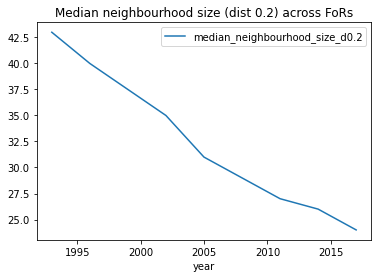

In [ ]:
year2median_neighsizes_02_df.plot(x="year", y="median_neighbourhood_size_d0.2")
plt.title('Median neighbourhood size (dist 0.2) across FoRs')

if embedding_type == "forembbyarticle":
  image_file_name = os.path.join(DIR_OUT, 
                                 'FoR_median_neighbourhood-d0.2-sim_time-series_'+embedding_type + 
                               '-embeddings' + 
                               '_Year_intervals-' + str(year_intervals) + 
                               '_level-' + str(f_code) +
                              '_num_dimensions-' + str(num_dimensions) + 
                              '_window_size-' + str(window_size) + 
                               '_negative_sampling-' + str(negative_sampling) + 
                               '.png')
elif embedding_type in ["title", "forembbyjournal"]:
  image_file_name = os.path.join(DIR_OUT, 
                                 'FoR_median_neighbourhood-d0.2-sim_time-series_'+embedding_type + 
                               '-embeddings' + 
                               '_Year_intervals-' + str(year_intervals) + 
                               '_level-' + str(f_code) +
                               '_num_dimensions-' + str(num_dimensions) + 
                               '.png')


plt.savefig(image_file_name)

## Trend test

I use the Mann Kendall test to see if the average neighbourhood size has a statistically significant upward or downward trend:

In [ ]:
(cor, p) = scipy.stats.kendalltau(year2average_neighsizes_02_df["year"], 
                                  year2average_neighsizes_02_df["average_neighbourhood_size_d0.2"])
(cor, p)

(-0.9444444444444445, 4.96031746031746e-05)

In [ ]:
out_file.write("Results of Mann Kendall correlation test on average neighbourhood sizes: corr = {}, p-value = {}".format(cor, p) + "\n")
if p < 0.05:
  out_file.write("Statistically significant\n")
else:
  out_file.write("Not statistically significant\n")


I use the Mann Kendall test to see if the median neighbourhood size has a statistically significant upward or downward trend:

In [ ]:
(cor, p) = scipy.stats.kendalltau(year2median_neighsizes_02_df["year"], 
                                  year2median_neighsizes_02_df["median_neighbourhood_size_d0.2"])
(cor, p)

NameError: ignored

In [ ]:
out_file.write("Results of Mann Kendall correlation test on median neighbourhood sizes: corr = {}, p-value = {}".format(cor, p) + "\n")
if p < 0.05:
  out_file.write("Statistically significant\n")
else:
  out_file.write("Not statistically significant\n")

Close output file

In [ ]:
out_file.close()